<a href="https://colab.research.google.com/github/HoangPhiHung1081/trajectory-clustering/blob/main/PH%C3%82N_C%E1%BB%A4M_CHUY%E1%BB%82N_%C4%90%E1%BB%98NG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nhập đường dẫn thư mục video: /content/drive/MyDrive/test

KẾT QUẢ PHÂN CỤM
- Silhouette Score: 1.000
- Số cụm: 4


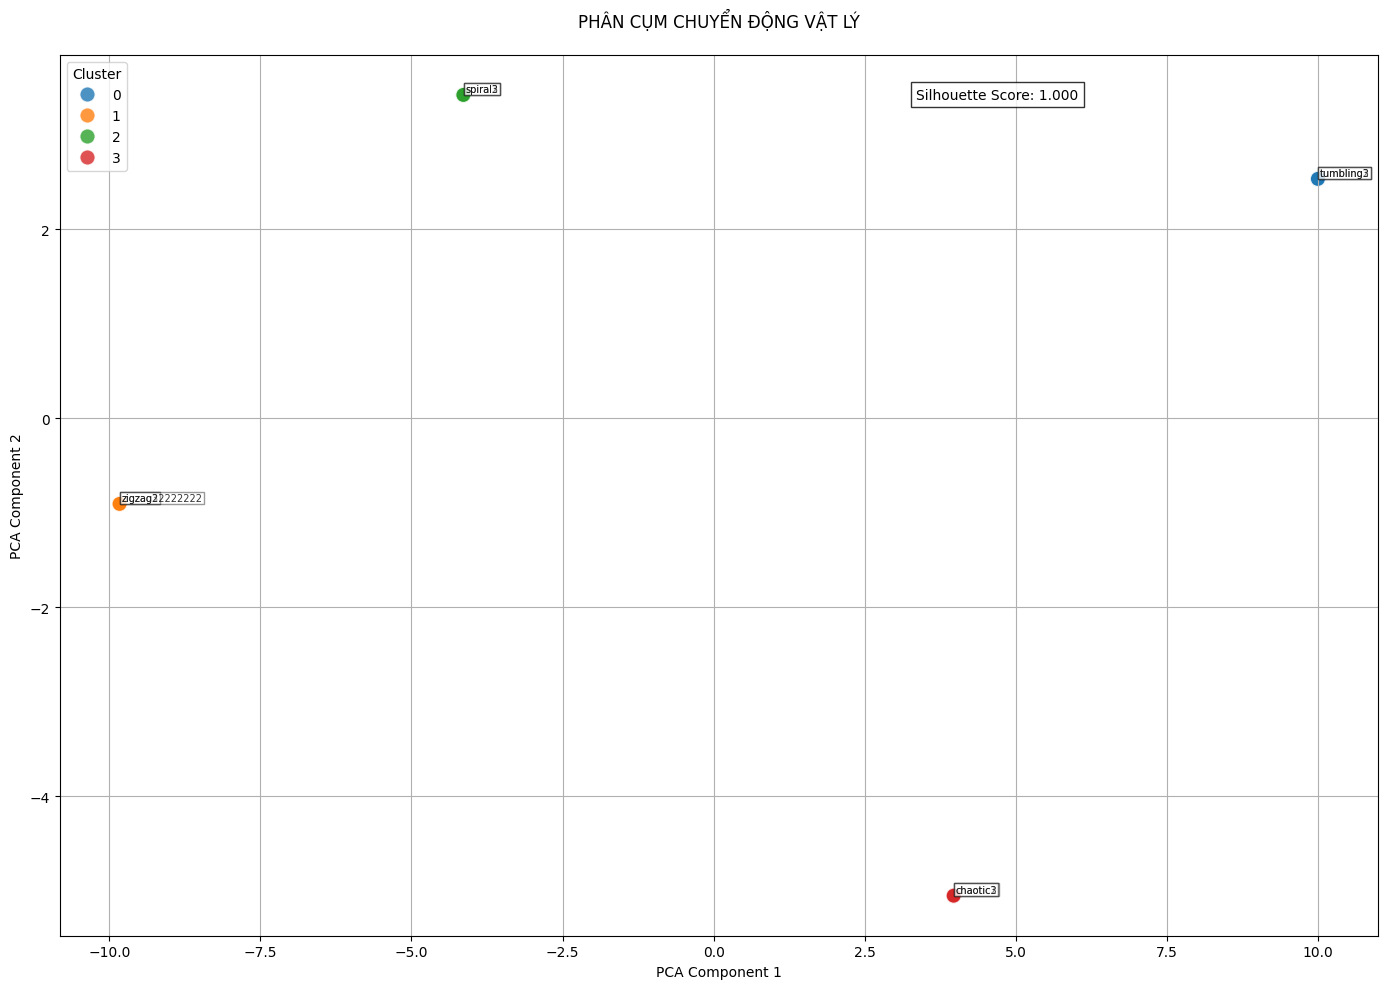

Cụm 0 (3 video):
  - tumbling1.mp4
  - tumbling2.mp4
  - tumbling3.mp4
Cụm 1 (3 video):
  - zigzag1.mp4
  - zigzag3.mp4
  - zigzag22222222.mp4
Cụm 2 (3 video):
  - spiral1.mp4
  - spiral2.mp4
  - spiral3.mp4
Cụm 3 (3 video):
  - chaotic1.mp4
  - chaotic2.mp4
  - chaotic3.mp4


In [ ]:
"""
TRÍCH XUẤT ĐẶC TRƯNG VẬT LÝ VÀ PHÂN CỤM CHUYỂN ĐỘNG
----------------------------------------------------
Code này thực hiện:
1. Trích xuất đặc trưng vật lý từ video chuyển động
2. Phân cụm bằng Autoencoder và KMeans
"""

# STEP 0: Import thư viện cần thiết
import os
import logging
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks

# Thư viện sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Thư viện PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Cấu hình logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Hằng số
THRESHOLD_VALUE = 200  # Ngưỡng nhị phân hóa ảnh
MIN_CONTOUR_AREA = 50  # Diện tích contour tối thiểu (pixel)
MIN_FRAMES = 3  # Số frame tối thiểu để phân tích
NU_AIR = 1.5e-5  # Hệ số nhớt không khí (m²/s)
PIXEL_TO_METER = 0.001  # Tỉ lệ pixel sang mét


# STEP 1: Trích xuất đặc trưng từ video
def extract_physical_quantities(video_path):
    try:
        # Mở video và kiểm tra
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Không thể mở video: {video_path}")

        # Lấy thông số video
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps <= 0:
            logging.warning(f"FPS không hợp lệ ({fps}) trong video {video_path}")
            return None

        trajectory = []
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Tiền xử lý frame
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)

            # Tìm contour
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest = max(contours, key=cv2.contourArea)
                if cv2.contourArea(largest) >= MIN_CONTOUR_AREA:
                    M = cv2.moments(largest)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        cy = int(M["m01"] / M["m00"])
                        trajectory.append((cx, cy, frame_count))

            frame_count += 1

        cap.release()

        # Kiểm tra số lượng frame hợp lệ
        trajectory = np.array(trajectory)
        if len(trajectory) < MIN_FRAMES:
            logging.warning(f"Quá ít điểm trong video: {os.path.basename(video_path)}")
            return None

        # Tính toán các đặc trưng
        coords = trajectory[:, :2]
        times = trajectory[:, 2] / fps

        # Tính quãng đường
        total_distance = np.sum([
            euclidean(coords[i], coords[i+1])
            for i in range(len(coords)-1)
        ])

        # Tính vận tốc
        velocities = []
        for i in range(len(times)-1):
            time_diff = times[i+1] - times[i]
            if time_diff > 0:
                velocities.append(euclidean(coords[i+1], coords[i]) / time_diff)

        velocities = np.array(velocities)
        mean_speed = np.mean(velocities) if len(velocities) > 0 else 0
        std_speed = np.std(velocities) if len(velocities) > 0 else 0

        # Tính các đặc trưng hình học
        width = np.max(coords[:, 0]) - np.min(coords[:, 0])
        height = np.max(coords[:, 1]) - np.min(coords[:, 1])
        aspect_ratio = width / height if height != 0 else 0
        total_time = times[-1] - times[0] if len(times) > 1 else 0

        # Tính đặc trưng chuyển động
        num_x_direction_changes = np.sum(np.diff(np.sign(np.diff(coords[:, 0]))) != 0)
        peaks, _ = find_peaks(coords[:, 1])
        num_y_peaks = len(peaks)

        # Tính độ cong
        def compute_curvature(xy):
            diffs = np.diff(xy, axis=0)
            norms = np.linalg.norm(diffs, axis=1)
            mask = norms > 1e-8
            if np.sum(mask) < 2:
                return 0
            directions = diffs[mask] / norms[mask, np.newaxis]
            ddirections = np.diff(directions, axis=0)
            return np.mean(np.linalg.norm(ddirections, axis=1))

        mean_curvature = compute_curvature(coords)

        # Tính tần số chính
        def dominant_frequency(signal):
            signal = signal - np.mean(signal)
            if len(signal) < 4:
                return 0
            fft = np.fft.fft(signal)
            freq = np.fft.fftfreq(len(signal))
            power = np.abs(fft)
            pos_mask = freq > 0
            return freq[pos_mask][np.argmax(power[pos_mask])] if np.any(pos_mask) else 0

        dominant_freq_x = dominant_frequency(coords[:, 0])
        dominant_freq_y = dominant_frequency(coords[:, 1])

        # Tính số Reynolds
        diameter_pixel = 50  # Giả định đường kính vật thể
        diameter_m = diameter_pixel * PIXEL_TO_METER
        mean_speed_m_s = mean_speed * PIXEL_TO_METER
        Re = (mean_speed_m_s * diameter_m) / NU_AIR if NU_AIR > 0 else 0

        # Tính moment quán tính
        radius_m = diameter_m / 2
        I = 0.5 * (radius_m ** 2)

        return {
            "total_distance": np.nan_to_num(total_distance),
            "mean_speed": np.nan_to_num(mean_speed),
            "std_speed": np.nan_to_num(std_speed),
            "aspect_ratio": np.nan_to_num(aspect_ratio),
            "total_time_sec": np.nan_to_num(total_time),
            "num_x_direction_changes": np.nan_to_num(num_x_direction_changes),
            "num_y_peaks": np.nan_to_num(num_y_peaks),
            "mean_curvature": np.nan_to_num(mean_curvature),
            "dominant_freq_x": np.nan_to_num(dominant_freq_x),
            "dominant_freq_y": np.nan_to_num(dominant_freq_y),
            "Re": np.nan_to_num(Re),
            "I": np.nan_to_num(I),
            "video_name": os.path.basename(video_path)
        }

    except Exception as e:
        logging.error(f"Lỗi khi xử lý video {video_path}: {str(e)}")
        return None



# STEP 2: Xử lý toàn bộ thư mục video
def process_video_folder(folder_path):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder không tồn tại: {folder_path}")

    video_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".mp4", ".avi", ".mov"))
    ]

    if not video_files:
        logging.warning(f"Không tìm thấy video trong {folder_path}")
        return None

    results = []
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        features = extract_physical_quantities(video_path)
        if features:
            results.append(features)

    return pd.DataFrame(results) if results else None



# STEP 3: Tiền xử lý dữ liệu
def preprocess_data(df):
    if df is None or df.empty:
        raise ValueError("DataFrame empty")

    feature_cols = [
        'total_distance', 'mean_speed', 'std_speed', 'aspect_ratio',
        'total_time_sec', 'num_x_direction_changes', 'num_y_peaks',
        'mean_curvature', 'dominant_freq_x', 'dominant_freq_y', 'Re', 'I'
    ]

    # Log-transform
    for col in ['std_speed', 'Re', 'total_distance']:
        df[col] = np.log1p(df[col])

    # Chuẩn hóa dữ liệu
    scaler = PowerTransformer()
    X_scaled = scaler.fit_transform(df[feature_cols])

    return X_scaled, feature_cols



# STEP 4: Mô hình Autoencoder
class MotionAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train_autoencoder(X_scaled, epochs=100):
    """Huấn luyện autoencoder"""
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = MotionAutoencoder(input_dim=X_scaled.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in loader:
            optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[0])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        if (epoch+1) % 20 == 0:
            logging.info(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model, losses



# STEP 5: Phân cụm và đánh giá
def cluster_and_evaluate(model, X_scaled, df, expected_clusters=4):
    """Phân cụm và trực quan hóa kết quả nếu đủ cluster"""

    with torch.no_grad():
        latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

    # Phân cụm KMeans
    kmeans = KMeans(n_clusters=expected_clusters, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(latent)
    df['cluster'] = clusters

    unique_clusters = np.unique(clusters)
    num_clusters_found = len(unique_clusters)

    print("\nKẾT QUẢ PHÂN CỤM")

    if num_clusters_found == 1:
        print("- Tất cả dữ liệu thuộc 1 cụm duy nhất.")
    elif num_clusters_found < expected_clusters:
        print(f"- Phát hiện {num_clusters_found} cụm, thấp hơn số cụm mong muốn {expected_clusters}.")
        print("⚠️ Không vẽ biểu đồ.")
    else:
        # Tính silhouette score
        score = silhouette_score(latent, clusters)
        print(f"- Silhouette Score: {score:.3f}")
        print(f"- Số cụm: {num_clusters_found}")

        # Vẽ biểu đồ phân cụm với PCA 2D
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latent)

        # Chuẩn hóa để tránh lỗi kích thước hình quá lớn
        max_abs = np.max(np.abs(latent_2d))
        if max_abs > 0:
            latent_2d = latent_2d / max_abs * 10

        plt.figure(figsize=(14, 10))
        ax = sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                            hue=clusters, palette="tab10", s=120, alpha=0.8)

        for i, (x, y) in enumerate(latent_2d):
            name = os.path.splitext(df.iloc[i]["video_name"])[0]
            ax.text(x + 0.03, y + 0.03, name,
                    fontsize=7,
                    alpha=0.8,
                    bbox=dict(facecolor='white', alpha=0.4, pad=1))

        plt.text(0.65, 0.95,
                 f'Silhouette Score: {score:.3f}',
                 transform=ax.transAxes,
                 bbox=dict(facecolor='white', alpha=0.8))

        plt.title("PHÂN CỤM CHUYỂN ĐỘNG VẬT LÝ", pad=20)
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend(title='Cluster')
        plt.grid(True)
        try:
            plt.tight_layout()
        except Exception:
            pass
        plt.show()

    # In tên video theo từng cluster cho tất cả trường hợp
    for c in unique_clusters:
        videos_in_cluster = df[df['cluster'] == c]['video_name'].tolist()
        print(f"Cụm {c} ({len(videos_in_cluster)} video):")
        for v in videos_in_cluster:
            print(f"  - {v}")

    return df





# HÀM MAIN
def main():
    try:
        # Đường dẫn
        folder_path = input("Nhập đường dẫn thư mục video: ").strip()

        # Xử lý video
        logging.info("Bắt đầu trích xuất đặc trưng...")
        df = process_video_folder(folder_path)
        if df is None or df.empty:
            logging.error("Không có dữ liệu hợp lệ để xử lý")
            return

        # Tiền xử lý
        logging.info("Chuẩn hóa dữ liệu...")
        X_scaled, _ = preprocess_data(df)

        # Huấn luyện mô hình
        logging.info("Huấn luyện Autoencoder...")
        model, losses = train_autoencoder(X_scaled)

        # Phân cụm
        logging.info("Phân cụm dữ liệu...")
        df = cluster_and_evaluate(model, X_scaled, df)

        # Lưu kết quả
        output_dir = "results"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "motion_clusters.csv")
        df.to_csv(output_path, index=False)
        logging.info(f"Đã lưu kết quả tại: {output_path}")

    except Exception as e:
        logging.error(f"Lỗi trong quá trình xử lý: {str(e)}")

if __name__ == "__main__":
    main()